## Automatic Spam Detection through NLP and Machine Learning Models 
### Equipo 3

In [2]:
# Importar las librerias que se necesitan
import pandas as pd
import statistics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline



### Carga de datos
Se cargan los datos de spam de correo electrónico de 3 archivos CSV proporcionados por el Socio Formador en dataframes de Pandas separados para luego ser combinados en un solo dataframe llamado 'data'. Se eliminan valores nulos, se convierete 'Spam' y 'NotSpam' en la columna 'closeNotes' a valores numéricos 1 y 0 respectivamente. Se concatenan todos los datos en 'combined_text y se muestra las primeras filas del dataframe.

In [3]:
# Cargar los datos
data1 = pd.read_csv('SpamData_1.csv', delimiter=';', quoting=3, skipinitialspace=True, error_bad_lines=False)
data2 = pd.read_csv('SpamData_2.csv', delimiter=';', quoting=3, skipinitialspace=True, error_bad_lines=False)
data3 = pd.read_csv('SpamData_3.csv', delimiter=';', quoting=3, skipinitialspace=True, error_bad_lines=False)

# Crear un solo dataframe
data = pd.concat([data1, data2, data3], ignore_index=True)

# Quitar valores nulos
data = data.fillna('')

# Convertir 'Spam' y 'NotSpam' a 1 y 0
data['closeNotes'] = data['closeNotes'].apply(lambda x: 1 if x == 'Spam' else 0)

# Concatenación de los datos en una sola columna
data['combined_text'] = data[['Attachment Count', 'Attachment Extension', 'Email From', 'Email Subject']].astype(str).agg(' '.join, axis=1)

# Data Info
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24982 entries, 0 to 24981
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Attachment Count      24982 non-null  object
 1   Attachment Extension  24982 non-null  object
 2   Email From            24982 non-null  object
 3   Email Subject         24982 non-null  object
 4   closeNotes            24982 non-null  int64 
 5   combined_text         24982 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


,Attachment Count,Attachment Extension,Email From,Email Subject,closeNotes,combined_text
0,5,"png,png,png,png,png",Nancy Wake <nancy.wake@medius-group.com>,RE: Let’s schedule a time to chat - Vaishnavi,1,"5.0 png,png,png,png,png Nancy Wake <nancy.wake..."
1,,,Recertification Do-Not-Reply <Recertification@...,EN: Please review your groups (User Move of Ze...,0,Recertification Do-Not-Reply <Recertificatio...
2,1,,Andre.Chen@tesa.com,"""ReportedMail:3|8ead432f-82f1-4ee1-8007-08dbf1...",0,"1.0 Andre.Chen@tesa.com ""ReportedMail:3|8ead4..."
3,1,,Holger.Sander.external@tesa.com,ReportedMail:3|b6bc0773-179f-41cf-b2f2-08dbf15...,0,1.0 Holger.Sander.external@tesa.com ReportedM...
4,,,Development of Care Models – Value-Based,Developing Health Care Value-Based Models in a...,1,Development of Care Models – Value-Based Dev...


### Distribución en el dataframe
Se crea una gráfica de barras que muestra la cantidad de correos electrónicos en cada categoría ("Spam" y "Not Spam") en el dataframe.

0    16698
1     8284
Name: closeNotes, dtype: int64


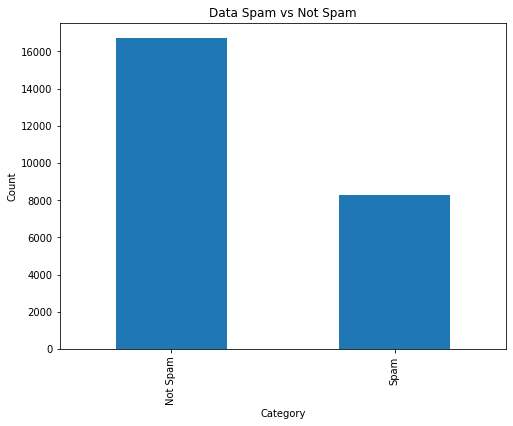

In [4]:
# Graficar el número de Spam y Not Spam en los datos
plt.figure(figsize=(8, 6))

# Frecuencia
value_counts = data['closeNotes'].value_counts()

print(value_counts)

value_counts.plot(kind='bar', title='Data Spam vs Not Spam')
plt.xlabel('Category')
plt.ylabel('Count')

labels = ['Not Spam' if x == 0 else 'Spam' for x in value_counts.index.tolist()]
plt.xticks(ticks=range(len(labels)), labels=labels)

# Mostrar gráfica
plt.show()

### Pre-procesamiento
Se crea una función que hace el pre-procesamiento de los datos, es decir, se hace una limpieza del texto en columnas específicas del dataframe, lo que implica eliminar hashtags, URLs, caracteres especiales, espacios, letras individuales e identificadores de Twitter.

In [5]:
def cleanData(data, name):
    data[name] = data[name].astype(str)
    data[name] = data[name].str.lower()
    # Quitar hashtags
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Quitar enlaces
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "LINK", x))
    # Quitar caracteres especiales
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Quitar espacios múltiples
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Quitar letras individuales
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # Quitar identificadores de Twitter
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))

Después de definir la función cleanData, se aplica esta función a varias columnas del dataframe como 'combined_text', 'Attachment Count', 'Attachment Extension', 'Email From' y 'Email Subject'.

In [6]:
cleanData(data, 'combined_text')
cleanData(data, 'Attachment Count')
cleanData(data, 'Attachment Extension')
cleanData(data, 'Email From')
cleanData(data, 'Email Subject')

# Mostrar resultados
data

,Attachment Count,Attachment Extension,Email From,Email Subject,closeNotes,combined_text
0,5 0,png png png png png,nancy wake nancy wake medius group com,re letscheduletime to chat vaishnavi,1,5 0 png png png png png nancy wake nancy wake ...
1,,,recertification do not reply recertification b...,en please review your groups user move of zeys...,0,recertification do not reply recertification b...
2,1 0,,andre chen tesa com,reportedmail 3 8ead432f 82f1 4ee1 8007 08dbf15...,0,1 0 andre chen tesa com reportedmail 3 8ead432...
3,1 0,,holger sander external tesa com,reportedmail 3 b6bc0773 179f 41cf b2f2 08dbf15...,0,1 0 holger sander external tesa com reportedma...
4,,,development of care models value based,developing health care value based models infe...,1,development of care models value based develop...
...,...,...,...,...,...,...
24977,1,pdf,troy diller troy lgchronicle com,marketing advertising,0,1 pdf troy diller troy lgchronicle com marketi...
24978,1,png,sharedocument online hayo edudesigncaribbean cw,action required lsherman completed file friday...,0,1 png sharedocument online hayo edudesigncarib...
24979,1,xlsx,bc bmbatch bc bmbatch pp1700 beiersdorf com,open pos,0,1 xlsx bc bmbatch bc bmbatch pp1700 beiersdorf...
24980,1,,mr leon andrew hr ssmbuilders in,hola mariana maycot beiersdorf com,0,1 mr leon andrew hr ssmbuilders in hola marian...


Se crea un conjunto de stopwords en varios idiomas, se define una función para eliminar estas palabras y tokenizar el texto. Luego se aplica esta función a la columna 'combined_text' del dataframe 'data'.

In [7]:
# Stop Words
stop_words = set(stopwords.words('english'))
stop_words.update(stopwords.words('german'))
stop_words.update(stopwords.words('russian'))
stop_words.update(stopwords.words('french'))
stop_words.update(stopwords.words('greek'))
stop_words.update(stopwords.words('italian'))
stop_words.update(stopwords.words('portuguese'))
stop_words.update(stopwords.words('spanish'))
stop_words.update(stopwords.words('arabic'))

# Caracteres japoneses
japanese_stop_words = set(["の", "に", "は", "を", "た", "が", "で", "て", "と", "し", "れ", "さ"])
stop_words.update(japanese_stop_words)

# Caracteres chinos 
chinese_stop_words = set(["的", "一", "是", "了", "我", "不", "在", "人", "有", "他", "这", "个", "们", "中", "来", "上", "大", "为", "和", "国"])
stop_words.update(chinese_stop_words)

def rem_stopwords_tokenize(data,name):
    def getting(sen): #recibe una sentencia textual
        example_sent = sen
        filtered_sentence = []



        word_tokens = word_tokenize(example_sent)


        filtered_sentence = [w for w in word_tokens if not w in stop_words]


        return filtered_sentence
    # Usar la función "getting(sen)" para añadir lo editado a los datos
    x = [] # Almacena una sentencia textual
    for i in data[name].values: # Procesa la i-esima sentencia
        x.append(getting(i)) # Procesa cada sentencia y el resultado se guarda en x
    data[name]=x

rem_stopwords_tokenize(data, 'combined_text')
data


,Attachment Count,Attachment Extension,Email From,Email Subject,closeNotes,combined_text
0,5 0,png png png png png,nancy wake nancy wake medius group com,re letscheduletime to chat vaishnavi,1,"[5, 0, png, png, png, png, png, nancy, wake, n..."
1,,,recertification do not reply recertification b...,en please review your groups user move of zeys...,0,"[recertification, reply, recertification, beie..."
2,1 0,,andre chen tesa com,reportedmail 3 8ead432f 82f1 4ee1 8007 08dbf15...,0,"[1, 0, andre, chen, tesa, reportedmail, 3, 8ea..."
3,1 0,,holger sander external tesa com,reportedmail 3 b6bc0773 179f 41cf b2f2 08dbf15...,0,"[1, 0, holger, sander, external, tesa, reporte..."
4,,,development of care models value based,developing health care value based models infe...,1,"[development, care, models, value, based, deve..."
...,...,...,...,...,...,...
24977,1,pdf,troy diller troy lgchronicle com,marketing advertising,0,"[1, pdf, troy, diller, troy, lgchronicle, mark..."
24978,1,png,sharedocument online hayo edudesigncaribbean cw,action required lsherman completed file friday...,0,"[1, png, sharedocument, online, hayo, edudesig..."
24979,1,xlsx,bc bmbatch bc bmbatch pp1700 beiersdorf com,open pos,0,"[1, xlsx, bc, bmbatch, bc, bmbatch, pp1700, be..."
24980,1,,mr leon andrew hr ssmbuilders in,hola mariana maycot beiersdorf com,0,"[1, mr, leon, andrew, hr, ssmbuilders, hola, m..."


Se define una función para llevar a cabo la lematización y otra para reconstruir oraciones a partir de tokens

In [ ]:
# Función de lematización
def Lemmatization(data,name):
    lemmatizer = WordNetLemmatizer()
    def getting2(sen):
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        # Leer un archivo con una lista de palavras/raices
        # Guardar esas palavras en una lista
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]

        # Quitar caracteres menores con una longitud menor a 2
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Quitar números
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

        return cleaned_data_title
    # Usar la función "getting(sen)" para añadir lo editado a los datos
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

In [9]:
# Función para las oraciones
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Quitar dobles espacios
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

Se aplican las funciones a 'combined_text'

In [10]:
make_sentences(data, 'combined_text')
Lemmatization(data, 'combined_text')
make_sentences(data, 'combined_text')
data

,Attachment Count,Attachment Extension,Email From,Email Subject,closeNotes,combined_text
0,5 0,png png png png png,nancy wake nancy wake medius group com,re letscheduletime to chat vaishnavi,1,png png png png png nancy wake nancy wake medi...
1,,,recertification do not reply recertification b...,en please review your groups user move of zeys...,0,recertification reply recertification beiersdo...
2,1 0,,andre chen tesa com,reportedmail 3 8ead432f 82f1 4ee1 8007 08dbf15...,0,andre chen tesa reportedmail 8ead432f 82f1 4ee...
3,1 0,,holger sander external tesa com,reportedmail 3 b6bc0773 179f 41cf b2f2 08dbf15...,0,holger sander external tesa reportedmail b6bc0...
4,,,development of care models value based,developing health care value based models infe...,1,development care model value based developing ...
...,...,...,...,...,...,...
24977,1,pdf,troy diller troy lgchronicle com,marketing advertising,0,pdf troy diller troy lgchronicle marketing adv...
24978,1,png,sharedocument online hayo edudesigncaribbean cw,action required lsherman completed file friday...,0,png sharedocument online hayo edudesigncaribbe...
24979,1,xlsx,bc bmbatch bc bmbatch pp1700 beiersdorf com,open pos,0,xlsx bmbatch bmbatch pp1700 beiersdorf open
24980,1,,mr leon andrew hr ssmbuilders in,hola mariana maycot beiersdorf com,0,leon andrew ssmbuilders hola mariana maycot be...


Se hace la división de los datos en conjuntos de entrenamiento y prueba para las representaciones diferentes del texto: TF-IDF y Bag of Words (BoW)

In [11]:
x = data['combined_text']
y = data['closeNotes']

# Se define el tamaño para test, el 10% de los datos se utilizarán para pruebas y el 90% para entrenamiento
test_size = 0.1

# Convertir labels a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# División 
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(x, y, test_size=test_size, random_state=42)
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(x, y, test_size=test_size, random_state=42)

print("Tamaño del conjunto de train (TF-IDF):", len(X_tfidf_train))
print("Tamaño del conjunto de test (TF-IDF):", len(X_tfidf_test))
print("Tamaño del conjunto de train (BoW):", len(X_bow_train))
print("Tamaño del conjunto de test (BoW):", len(X_bow_test))


Tamaño del conjunto de train (TF-IDF): 22483
Tamaño del conjunto de test (TF-IDF): 2499
Tamaño del conjunto de train (BoW): 22483
Tamaño del conjunto de test (BoW): 2499


Se realiza la vectorización TF-IDF  en los conjuntos de entrenamiento y prueba.

In [12]:

TFIDF = TfidfVectorizer(tokenizer= word_tokenize,
                        stop_words=[], 
                        ngram_range=(1,3), 
                        max_features = 1200)

X_tfidf_train = TFIDF.fit_transform(X_tfidf_train)
X_tfidf_test = TFIDF.transform(X_tfidf_test)

In [13]:
# Obtener las palabras únicas, las cuales constituiran los nombres de nuevas columnas
features_names_TFIDF = TFIDF.get_feature_names()
features_names_TFIDF

['08db9275e821',
 '08db9275e821 contactwithcompetitors',
 '08db9275e821 contactwithcompetitors beiersdorf',
 '08dc16a13952',
 '08dc16a13952 contactwithcompetitors',
 '08dc16a13952 contactwithcompetitors beiersdorf',
 '1st',
 '1to1help',
 '2fa',
 '2fa multifactor',
 '2fa multifactor detected',
 '2fa wednesday',
 '2fa wednesday september',
 '49ed',
 '49ed 08dc16a13952',
 '49ed 08dc16a13952 contactwithcompetitors',
 '4ccf',
 '4ccf 4ced',
 '4ccf 4ced 08db9275e821',
 '4ced',
 '4ced 08db9275e821',
 '4ced 08db9275e821 contactwithcompetitors',
 '4f49e50e',
 '4f49e50e bddb',
 '4f49e50e bddb 4ccf',
 '6sense',
 '6sense privacy',
 '6sense privacy notice',
 '91e7',
 '91e7 49ed',
 '91e7 49ed 08dc16a13952',
 'a3bc4fd1',
 'a3bc4fd1 91e7',
 'a3bc4fd1 91e7 49ed',
 'abonnement',
 'abonnement microsoft',
 'access',
 'access file',
 'access request',
 'account',
 'accounting',
 'ach',
 'across',
 'across organization',
 'action',
 'action awareness',
 'action awareness check',
 'action required',
 'activat

Se realiza la vectorización Bag of Words (BoW) en los conjuntos de entrenamiento y prueba.

In [14]:
BoW = CountVectorizer(tokenizer=word_tokenize, 
                      stop_words=[], 
                      ngram_range=(1,3), 
                      max_features=1200)

X_bow_train = BoW.fit_transform(X_bow_train)
X_bow_test = BoW.transform(X_bow_test)

In [15]:
# Hiperparámetros para el modelo Naive Bayes
nb_params = {
    'alpha': [0.01, 0.1, 1, 10]
}

# Hiperparámetros para el modelo de Regresión Logística
lr_params = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'classifier__max_iter': [100, 200, 300, 500]
}

# Hiperparámetros para el modelo Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hiperparámetros para el modelo de Redes Neuronales (MLP)
mlp_params = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [200, 300, 400, 500]
}

# Modelos
models = [
    ('Naive Bayes', MultinomialNB(), nb_params),
    ('Logistic Regression', Pipeline([('scaler', MaxAbsScaler()), ('classifier', LogisticRegression(random_state=42))]), lr_params),
    ('Random Forest', RandomForestClassifier(random_state=42), rf_params),
    ('Neural Network', Pipeline([('scaler', MaxAbsScaler()), ('classifier', MLPClassifier(random_state=42))]), mlp_params)
]

Se define una función llamada trainMLmodels que entrena y evalúa modelos de aprendizaje automático utilizando validación cruzada. 

In [16]:
# Encuentra los mejores parámetros para cada modelo
def trainMLmodels(X_train, y_train, Nsplits=10):
    names = []
    results = []
    for name, model, params in models:
        grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        cv_results = cross_val_score(best_model, X_train, y_train, cv=Nsplits)
        names.append(name)
        results.append(cv_results)
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    return names, results

Se realiza este proceso tanto para los datos vectorizados con TF-IDF como para los datos vectorizados con Bag of Words.

In [17]:

# Evaluar los modelos usando cross-validation para TF-IDF
names_tfidf, results_tfidf = trainMLmodels(X_tfidf_train, y_tfidf_train, Nsplits=10)
for name, result in zip(names_tfidf, results_tfidf):
    print(f'Accuracy of {name} (mean ± std): {result.mean()} ± {result.std()}')

# Evaluar los modelos usando cross-validation para Bag of Words
names_bow, results_bow = trainMLmodels(X_bow_train, y_bow_train, Nsplits=10)
for name, result in zip(names_bow, results_bow):
    print(f'Accuracy of {name} (mean ± std): {result.mean()} ± {result.std()}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best parameters for Naive Bayes: {'alpha': 10}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__solver': 'newton-cg'}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [ ]:
# Mejores hiperparámetros para cada modelo
modelsParams = [
    ('Naive Bayes', MultinomialNB(), {'alpha': 10}),
    ('Logistic Regression', Pipeline([('scaler', MaxAbsScaler()), ('classifier', LogisticRegression(random_state=42))]), {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__solver': 'newton-cg'}),
    ('Random Forest', RandomForestClassifier(random_state=42), {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}),
    ('Neural Network', Pipeline([('scaler', MaxAbsScaler()), ('classifier', MLPClassifier(random_state=42))]), {'classifier__hidden_layer_sizes': (100,), 'classifier__activation': 'relu', 'classifier__solver': 'adam', 'classifier__alpha': 0.0001, 'classifier__learning_rate': 'constant', 'classifier__max_iter': 500})
]


Se crea una función llamada trainMLmodelsKFold que entrena y evalúa los modelos utilizando validación cruzada de K-Fold.

In [19]:
def trainMLmodelsKFold(X_train, y_train, Nsplits):
    
    results = []
    names = []

    for name, model, params in modelsParams:
        print(f'Processing: {name}')
        model.set_params(**params)
        kfold = KFold(n_splits=Nsplits)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
        names.append(name)
        results.append(cv_results)

    return names, results

In [20]:
# Evaluar los modelos usando cross-validation para TF-IDF
names_tfidf, results_tfidf = trainMLmodelsKFold(X_tfidf_train, y_tfidf_train, Nsplits=10)
for name, result in zip(names_tfidf, results_tfidf):
    print(f'TF-IDF Accuracy of {name} (mean ± std): {result.mean():.4f} ± {result.std():.4f}')

# Evaluar los modelos usando cross-validation para Bag of Words
names_bow, results_bow = trainMLmodelsKFold(X_bow_train, y_bow_train, Nsplits=10)
for name, result in zip(names_bow, results_bow):
    print(f'Bag of Words Accuracy of {name} (mean ± std): {result.mean():.4f} ± {result.std():.4f}')

Processing: Naive Bayes
Processing: Logistic Regression
Processing: Random Forest
Processing: Neural Network
TF-IDF Accuracy of Naive Bayes (mean ± std): 0.8470 ± 0.0077
TF-IDF Accuracy of Logistic Regression (mean ± std): 0.8810 ± 0.0056
TF-IDF Accuracy of Random Forest (mean ± std): 0.8891 ± 0.0047
TF-IDF Accuracy of Neural Network (mean ± std): 0.8916 ± 0.0040
Processing: Naive Bayes
Processing: Logistic Regression
Processing: Random Forest
Processing: Neural Network


Se hace un análisis del desempeño de los modelos utilizando boxplots y calculando las medianas de los resultados.

In [ ]:
# Medianas con los resultados de TF-IDF
def cmedianas(results):
  medianas=[]
  for i in range(len(results)):
    medianas.append(round(statistics.median(results[i]),4))
  return medianas


# Analizar el desempeño
medianas = cmedianas(results_tfidf)
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data = results_tfidf, ax = ax)
ax.set_xticklabels(names_tfidf)
vertical_offset=statistics.median(medianas)*0.005

for xtick in ax.get_xticks():
    ax.text(xtick,medianas[xtick]+vertical_offset,medianas[xtick],horizontalalignment='center',color='w',size='x-large',weight='semibold')

plt.title(f'Precisión de los modelos con 10 splits',fontsize=20,fontweight='bold')
plt.show()

In [ ]:
# Medianas con los resultados de Bag of Words
def cmedianas(results):
  medianas=[]
  for i in range(len(results)):
    medianas.append(round(statistics.median(results[i]),4))
  return medianas


# Analizar el desempeño
medianas = cmedianas(results_bow)
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data = results_bow, ax = ax)
ax.set_xticklabels(names_bow)
vertical_offset=statistics.median(medianas)*0.005

for xtick in ax.get_xticks():
    ax.text(xtick,medianas[xtick]+vertical_offset,medianas[xtick],horizontalalignment='center',color='w',size='x-large',weight='semibold')

plt.title(f'Precisión de los modelos con 10 splits',fontsize=20,fontweight='bold')
plt.show()

Se evalúa el desempeño de los modelos entrenados en el conjunto de pruebas (para TF-IDF) y el conjunto de entrenamiento (para BoW). Se calcula y se imprime el informe de precisión y clasificación, así como la matriz de confusión para cada modelo.

In [ ]:
# TF-IDF
for i in range(len(names_tfidf)):
    model = modelsParams[i][1]
    model.set_params(**modelsParams[i][2])
    model.fit(X_tfidf_train, y_tfidf_train)
    predictions = model.predict(X_tfidf_test)

    print(f'Precisión del test para {names_tfidf[i]}: \n')
    print(f'Accuracy: {accuracy_score(y_tfidf_test, predictions)}\n')
    print(f'{classification_report(y_tfidf_test, predictions)}')

    # Matriz de Confusión
    conf_matrix = confusion_matrix(y_tfidf_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {names_tfidf[i]}', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# BoW
for i in range(len(names_bow)):
    model = modelsParams[i][1]
    model.set_params(**modelsParams[i][2])
    model.fit(X_bow_train, y_bow_train)
    predictions = model.predict(X_bow_train)

    print(f'Precisión del test para {names_bow[i]}: \n')
    print(f'Accuracy: {accuracy_score(y_bow_train, predictions)}\n')
    print(f'{classification_report(y_bow_train, predictions)}')

    # Matriz de Confusión
    conf_matrix = confusion_matrix(y_bow_train, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {names_bow[i]}', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()